In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
# from upsetplot import from_contents, plot
from matplotlib import pyplot

from pathlib import Path

In [2]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [3]:
design_matrix = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [4]:
design_matrix.shape

(680, 64)

In [5]:
clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    "map_ambulance",
    "mental_status_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "crp_day1",
    "trc_emergency_department",
    "sex",
    "age"
]

continuous_clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    "map_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "trc_emergency_department",
    "crp_day1",
    "age"
]

categorical_clinical_columns = [
    "mental_status_ambulance", 
]

In [6]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer



In [7]:
design_matrix['survival_30_day'] = np.where(design_matrix['survival_days'] <= 30, 1, 0)
design_matrix_test['survival_30_day'] = np.where(design_matrix_test['survival_days'] <= 30, 1, 0)

In [8]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors

bootstrap_results = {}

from sklearn.utils import shuffle

for bootstrap in range(100):

    X_sample = design_matrix.sample(
        frac=0.9,
        replace=False,
        random_state=bootstrap
    )

    clinical_scaler = StandardScaler()

    clinical_imputer = SimpleImputer()
    constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

    X_sample[continuous_clinical_columns] = clinical_imputer.fit_transform(X_sample[continuous_clinical_columns])
    X_sample[categorical_clinical_columns] = constant_imputer.fit_transform(X_sample[categorical_clinical_columns])

    X_sample[continuous_clinical_columns] = clinical_scaler.fit_transform(X_sample[continuous_clinical_columns])

    X_test = design_matrix_test.copy()

    X_test[continuous_clinical_columns] = clinical_imputer.transform(X_test[continuous_clinical_columns])
    X_test[categorical_clinical_columns] = constant_imputer.transform(X_test[categorical_clinical_columns])

    X_test[continuous_clinical_columns] = clinical_scaler.transform(X_test[continuous_clinical_columns])

    #X_sample = X.copy()

    neighbors = NearestNeighbors(
        n_neighbors=10, #round(design_matrix.shape[0] * 0.01),
        metric="euclidean"
        #p=4
    )

    neighbors.fit(X_sample[clinical_columns])
    distances, knn_results = neighbors.kneighbors(X_test[clinical_columns], return_distance=True)

    neighborhood_sizes = []

    mean_distance = []

    mortality_30s = []
    mortality_30_prob = []


    for i in range(knn_results.shape[0]):

        #if distances[i].max() < distances.mean():

        knn_idx = knn_results[i, :]

        if knn_idx.size > 0:

            neighborhood = X_sample.iloc[knn_idx, :].copy()

            neighborhood_sizes.append(neighborhood.shape[0])

            mean_distance.append(
                distances[i].mean()
            )

            mortality_30 = np.where(neighborhood['survival_days'] <= 30, 1, 0)

            mortality_probability_30 = mortality_30.sum() / neighborhood.shape[0]

            mortality_30s.append(mortality_30)
            mortality_30_prob.append(mortality_probability_30)

    
    bootstrap_results[f"bootstrap_{bootstrap}"] = mortality_30_prob


In [9]:
X_test = pd.concat([X_test,  pd.DataFrame(bootstrap_results)], axis=1)

In [10]:
X_test['Mortality 30 Day Prob'] = X_test[list(bootstrap_results.keys())].mean(axis=1)

In [11]:

bootstrap_counts = []


for bootstrap_iteration in list(bootstrap_results.keys()):


    mort_range = X_test[bootstrap_iteration].unique()
    mort_range.sort()
    actual_mort = []
    #mort_range = mort_range[:-1]
    counts_per_bin = []
    for val in mort_range:

        counts = X_test[X_test[bootstrap_iteration] == val]['survival_30_day'].value_counts()
        actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        counts_per_bin.append(counts.sum())

    estimated_mort = pd.DataFrame(
        {
            "Actual Mortality (30-Day)": actual_mort,
            "Estimated Mortality (30-Day)": mort_range,
            "Counts": counts_per_bin
        }
    )

    bootstrap_counts.append(estimated_mort)

In [12]:
bootstrap_counts = pd.concat(bootstrap_counts)

In [13]:
bootstrap_counts.head(20)

,Actual Mortality (30-Day),Estimated Mortality (30-Day),Counts
0,0.077830,0.0,424
1,0.158940,0.1,151
2,0.187500,0.2,64
3,0.222222,0.3,27
4,0.666667,0.4,9
5,0.500000,0.5,4
6,1.000000,0.6,1
0,0.062189,0.0,402
1,0.164634,0.1,164
2,0.200000,0.2,70


In [14]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [15]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(bootstrap_counts[['Estimated Mortality (30-Day)']], bootstrap_counts[['Actual Mortality (30-Day)']])

LinearRegression()

In [16]:
from scipy.stats import linregress


linregress_results = linregress(bootstrap_counts[['Estimated Mortality (30-Day)']].values.ravel(), bootstrap_counts[['Actual Mortality (30-Day)']].values.ravel())
linregress_results


LinregressResult(slope=1.3493435340162019, intercept=0.0015800702464249805, rvalue=0.8526958770876849, pvalue=8.061131780319741e-191, stderr=0.03196132895900348, intercept_stderr=0.011101252874838518)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = linregress_results.intercept + linregress_results.slope*bootstrap_counts[['Estimated Mortality (30-Day)']].values.ravel()

In [18]:
from scipy.stats import pearsonr

corr, pval = pearsonr(
    bootstrap_counts[['Estimated Mortality (30-Day)']].values.ravel(), bootstrap_counts[['Actual Mortality (30-Day)']].values.ravel()
)

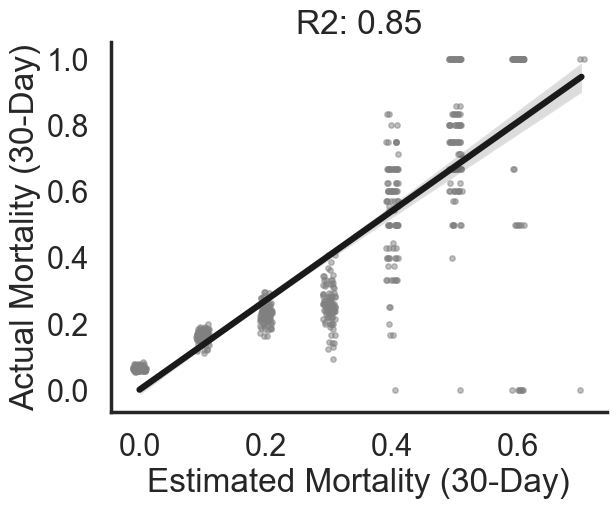

In [19]:
import matplotlib.pyplot as plt

sns.set_theme(context="poster", style="white", font_scale=1)

fig, ax = plt.subplots()

sns.regplot(
    data=bootstrap_counts,
    x="Estimated Mortality (30-Day)",
    y="Actual Mortality (30-Day)",
    ax=ax,
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 15},
    line_kws={"color": "k", "alpha": 1},
    fit_reg=True,
    ci=95,
    x_jitter=0.01
)

ax.set_title(
    f"R2: {corr:.2f}"
)

sns.despine()


In [20]:
estimated_mort['Predicted Fit'] = linreg.predict(estimated_mort[['Estimated Mortality (30-Day)']])

In [21]:
fig.savefig("mortality.pdf", dpi=300, bbox_inches="tight")

In [22]:
X_test.to_csv(
    "design_matrix_test_mortality_risk.tsv",
    sep="\t"
)

# Deterioration

In [23]:
X_subset = design_matrix[
    #(X['sofa_score_increase_day1'] < 2) &
    (~design_matrix['sofa_score_increase_day2'].isna()) &
    (~design_matrix['sofa_score_increase_day3'].isna())
].copy()

In [24]:
X_test_subset = design_matrix_test[
     #(X_test['sofa_score_increase_day1'] < 2) &
    (~design_matrix_test['sofa_score_increase_day2'].isna()) &
    (~design_matrix_test['sofa_score_increase_day3'].isna())
].copy()

In [25]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors

bootstrap_results = {}

from sklearn.utils import shuffle

for bootstrap in range(100):

    X_sample = X_subset.sample(
        frac=0.9,
        replace=False,
        random_state=bootstrap
    )

    clinical_scaler = StandardScaler()

    clinical_imputer = SimpleImputer()
    constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

    X_sample[continuous_clinical_columns] = clinical_imputer.fit_transform(X_sample[continuous_clinical_columns])
    X_sample[categorical_clinical_columns] = constant_imputer.fit_transform(X_sample[categorical_clinical_columns])

    X_sample[continuous_clinical_columns] = clinical_scaler.fit_transform(X_sample[continuous_clinical_columns])

    X_test = X_test_subset.copy()

    X_test[continuous_clinical_columns] = clinical_imputer.transform(X_test[continuous_clinical_columns])
    X_test[categorical_clinical_columns] = constant_imputer.transform(X_test[categorical_clinical_columns])

    X_test[continuous_clinical_columns] = clinical_scaler.transform(X_test[continuous_clinical_columns])

    #X_sample = X.copy()

    neighbors = NearestNeighbors(
        n_neighbors=10, #round(design_matrix.shape[0] * 0.01),
        metric="euclidean"
        #p=4
    )

    neighbors.fit(X_sample[clinical_columns])
    distances, knn_results = neighbors.kneighbors(X_test[clinical_columns], return_distance=True)

    neighborhood_sizes = []

    mean_distance = []

    sepsis_developments = []


    for i in range(knn_results.shape[0]):

        #if distances[i].max() < distances.mean():

        knn_idx = knn_results[i, :]

        if knn_idx.size > 0:

            neighborhood = X_sample.iloc[knn_idx, :].copy()

            neighborhood_sizes.append(neighborhood.shape[0])

            mean_distance.append(
                distances[i].mean()
            )

            sepsis_development = np.where(
                neighborhood['sofa_score_increase_day2'] > 1, 1, np.where(
                    neighborhood['sofa_score_increase_day3'] > 1, 1, 0
                )
            )

            sepsis_development_prob = sepsis_development.sum() / neighborhood.shape[0]

            sepsis_developments.append(sepsis_development_prob)


    bootstrap_results[f"deterioration_bootstrap_{bootstrap}"] = sepsis_developments


In [26]:
X_test_subset = pd.concat([X_test_subset.reset_index(drop=True), pd.DataFrame(bootstrap_results)], axis=1)

In [27]:
X_test_subset['Future Deterioration Mean'] = X_test_subset[list(bootstrap_results.keys())].mean(axis=1)

In [28]:
X_test_subset['Deterioration Actual'] = np.where(
    X_test_subset['sofa_score_increase_day2'] > 1, 1, np.where(
        X_test_subset['sofa_score_increase_day3'] > 1, 1, 0
    )
)

In [29]:

bootstrap_counts = []


for bootstrap_iteration in list(bootstrap_results.keys()):


    mort_range = X_test_subset[bootstrap_iteration].unique()
    mort_range.sort()
    actual_mort = []
    #mort_range = mort_range[:-1]
    counts_per_bin = []
    for val in mort_range:

        counts = X_test_subset[X_test_subset[bootstrap_iteration] == val]['Deterioration Actual'].value_counts()
        actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        counts_per_bin.append(counts.sum())

    estimated_mort = pd.DataFrame(
        {
            "Actual Deterioration": actual_mort,
            "Estimated Deterioration": mort_range,
            "Counts": counts_per_bin
        }
    )

    bootstrap_counts.append(estimated_mort)

In [30]:
bootstrap_counts = pd.concat(bootstrap_counts)

In [31]:
bootstrap_counts.head(20)

,Actual Deterioration,Estimated Deterioration,Counts
0,1.000000,0.0,1
1,0.166667,0.1,6
2,0.333333,0.2,21
3,0.482759,0.3,58
4,0.517647,0.4,85
5,0.568000,0.5,125
6,0.580420,0.6,143
7,0.595238,0.7,84
8,0.702128,0.8,47
9,0.944444,0.9,18


In [32]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [33]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(bootstrap_counts[['Estimated Deterioration']], bootstrap_counts[['Actual Deterioration']])

LinearRegression()

In [34]:
from scipy.stats import linregress


linregress_results = linregress(bootstrap_counts[['Estimated Deterioration']].values.ravel(), bootstrap_counts[['Actual Deterioration']].values.ravel())
linregress_results


LinregressResult(slope=0.6281245070307278, intercept=0.22425121769347506, rvalue=0.8510160470693072, pvalue=8.886396491015054e-292, stderr=0.012047936015825402, intercept_stderr=0.007340973206664894)

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = linregress_results.intercept + linregress_results.slope*bootstrap_counts[['Estimated Deterioration']].values.ravel()

In [36]:
from scipy.stats import pearsonr

corr, pval = pearsonr(
    bootstrap_counts[['Estimated Deterioration']].values.ravel(), bootstrap_counts[['Actual Deterioration']].values.ravel()
)

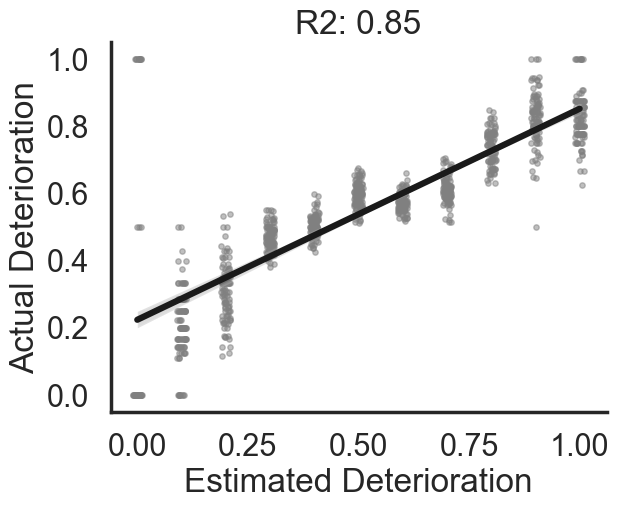

In [37]:
import matplotlib.pyplot as plt

sns.set_theme(context="poster", style="white", font_scale=1)

fig, ax = plt.subplots()

sns.regplot(
    data=bootstrap_counts,
    x="Estimated Deterioration",
    y="Actual Deterioration",
    ax=ax,
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 15},
    line_kws={"color": "k", "alpha": 1},
    fit_reg=True,
    ci=95,
    x_jitter=0.01
)

ax.set_title(
    f"R2: {corr:.2f}"
)

sns.despine()

In [38]:
fig.savefig("deterioration.pdf", dpi=300, bbox_inches="tight")

In [39]:
X_test_subset.to_csv(
    "design_matrix_test_deterioration.tsv",
    sep="\t"
)

# Sepsis

In [40]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors

bootstrap_results = {}

from sklearn.utils import shuffle

for bootstrap in range(100):

    X_sample = design_matrix.sample(
        frac=0.9,
        replace=False,
        random_state=bootstrap
    )

    clinical_scaler = StandardScaler()

    clinical_imputer = SimpleImputer()
    constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

    X_sample[continuous_clinical_columns] = clinical_imputer.fit_transform(X_sample[continuous_clinical_columns])
    X_sample[categorical_clinical_columns] = constant_imputer.fit_transform(X_sample[categorical_clinical_columns])

    X_sample[continuous_clinical_columns] = clinical_scaler.fit_transform(X_sample[continuous_clinical_columns])

    X_test = design_matrix_test.copy()

    X_test[continuous_clinical_columns] = clinical_imputer.transform(X_test[continuous_clinical_columns])
    X_test[categorical_clinical_columns] = constant_imputer.transform(X_test[categorical_clinical_columns])

    X_test[continuous_clinical_columns] = clinical_scaler.transform(X_test[continuous_clinical_columns])

    #X_sample = X.copy()

    neighbors = NearestNeighbors(
        n_neighbors=10, #round(design_matrix.shape[0] * 0.01),
        metric="euclidean"
        #p=4
    )

    neighbors.fit(X_sample[clinical_columns])
    distances, knn_results = neighbors.kneighbors(X_test[clinical_columns], return_distance=True)

    neighborhood_sizes = []

    mean_distance = []

    mortality_30s = []
    mortality_30_prob = []


    for i in range(knn_results.shape[0]):

        #if distances[i].max() < distances.mean():

        knn_idx = knn_results[i, :]

        if knn_idx.size > 0:

            neighborhood = X_sample.iloc[knn_idx, :].copy()

            neighborhood_sizes.append(neighborhood.shape[0])

            mean_distance.append(
                distances[i].mean()
            )

            mortality_30 = np.where(neighborhood['sepsis_or_septic_shock'] == 1, 1, 0)

            mortality_probability_30 = mortality_30.sum() / neighborhood.shape[0]

            mortality_30s.append(mortality_30)
            mortality_30_prob.append(mortality_probability_30)

    
    bootstrap_results[f"bootstrap_{bootstrap}"] = mortality_30_prob


In [41]:
X_test = pd.concat([design_matrix_test,  pd.DataFrame(bootstrap_results)], axis=1)

In [42]:
X_test['Sepsis Prob'] = X_test[list(bootstrap_results.keys())].mean(axis=1)

In [43]:

bootstrap_counts = []


for bootstrap_iteration in list(bootstrap_results.keys()):


    mort_range = X_test[bootstrap_iteration].unique()
    mort_range.sort()
    actual_mort = []
    #mort_range = mort_range[:-1]
    counts_per_bin = []
    for val in mort_range:

        counts = X_test[X_test[bootstrap_iteration] == val]['sepsis_or_septic_shock'].value_counts()
        actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        counts_per_bin.append(counts.sum())

    estimated_mort = pd.DataFrame(
        {
            "Actual Sepsis": actual_mort,
            "Estimated Sepsis": mort_range,
            "Counts": counts_per_bin
        }
    )

    bootstrap_counts.append(estimated_mort)

In [44]:
bootstrap_counts = pd.concat(bootstrap_counts)

In [45]:
bootstrap_counts.head(20)

,Actual Sepsis,Estimated Sepsis,Counts
0,0.000000,0.0,1
1,0.400000,0.1,5
2,0.250000,0.2,12
3,0.354839,0.3,31
4,0.307692,0.4,52
5,0.627451,0.5,102
6,0.660000,0.6,100
7,0.726619,0.7,139
8,0.807339,0.8,109
9,0.863636,0.9,88


In [46]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [47]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(bootstrap_counts[['Estimated Sepsis']], bootstrap_counts[['Actual Sepsis']])

LinearRegression()

In [48]:
from scipy.stats import linregress


linregress_results = linregress(bootstrap_counts[['Estimated Sepsis']].values.ravel(), bootstrap_counts[['Actual Sepsis']].values.ravel())
linregress_results


LinregressResult(slope=0.8318546604631879, intercept=0.11744759803026722, rvalue=0.9266831235561658, pvalue=0.0, stderr=0.010492115302180938, intercept_stderr=0.006395908777950818)

In [49]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = linregress_results.intercept + linregress_results.slope*bootstrap_counts[['Estimated Sepsis']].values.ravel()

In [50]:
from scipy.stats import pearsonr

corr, pval = pearsonr(
    bootstrap_counts[['Estimated Sepsis']].values.ravel(), bootstrap_counts[['Actual Sepsis']].values.ravel()
)

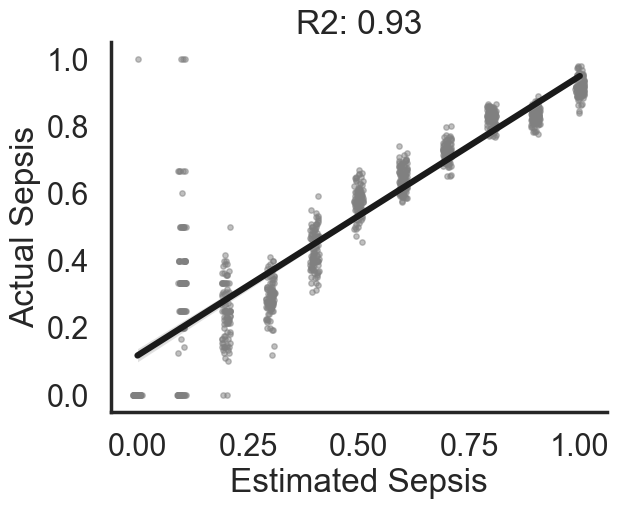

In [51]:
import matplotlib.pyplot as plt

sns.set_theme(context="poster", style="white", font_scale=1)

fig, ax = plt.subplots()

sns.regplot(
    data=bootstrap_counts,
    x="Estimated Sepsis",
    y="Actual Sepsis",
    ax=ax,
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 15},
    line_kws={"color": "k", "alpha": 1},
    fit_reg=True,
    ci=95,
    x_jitter=0.01
)

ax.set_title(
    f"R2: {corr:.2f}"
)

sns.despine()

In [52]:
X_test.to_csv(
    "design_matrix_test_sepsis_risk.tsv",
    sep="\t",
    index=False
)

In [53]:
fig.savefig("sepsis_diagnosis.pdf", dpi=300, bbox_inches="tight")

# Infection

In [54]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors

bootstrap_results = {}

from sklearn.utils import shuffle

for bootstrap in range(100):

    X_sample = design_matrix.sample(
        frac=0.9,
        replace=False,
        random_state=bootstrap
    )

    clinical_scaler = StandardScaler()

    clinical_imputer = SimpleImputer()
    constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

    X_sample[continuous_clinical_columns] = clinical_imputer.fit_transform(X_sample[continuous_clinical_columns])
    X_sample[categorical_clinical_columns] = constant_imputer.fit_transform(X_sample[categorical_clinical_columns])

    X_sample[continuous_clinical_columns] = clinical_scaler.fit_transform(X_sample[continuous_clinical_columns])

    X_test = design_matrix_test.copy()

    X_test[continuous_clinical_columns] = clinical_imputer.transform(X_test[continuous_clinical_columns])
    X_test[categorical_clinical_columns] = constant_imputer.transform(X_test[categorical_clinical_columns])

    X_test[continuous_clinical_columns] = clinical_scaler.transform(X_test[continuous_clinical_columns])

    #X_sample = X.copy()

    neighbors = NearestNeighbors(
        n_neighbors=10, #round(design_matrix.shape[0] * 0.01),
        metric="euclidean"
        #p=4
    )

    neighbors.fit(X_sample[clinical_columns])
    distances, knn_results = neighbors.kneighbors(X_test[clinical_columns], return_distance=True)

    neighborhood_sizes = []

    mean_distance = []

    mortality_30s = []
    mortality_30_prob = []


    for i in range(knn_results.shape[0]):

        #if distances[i].max() < distances.mean():

        knn_idx = knn_results[i, :]

        if knn_idx.size > 0:

            neighborhood = X_sample.iloc[knn_idx, :].copy()

            neighborhood_sizes.append(neighborhood.shape[0])

            mean_distance.append(
                distances[i].mean()
            )

            mortality_30 = np.where(neighborhood['verified_infection'] == 1, 1, 0)

            mortality_probability_30 = mortality_30.sum() / neighborhood.shape[0]

            mortality_30s.append(mortality_30)
            mortality_30_prob.append(mortality_probability_30)

    
    bootstrap_results[f"bootstrap_{bootstrap}"] = mortality_30_prob


In [55]:
X_test = pd.concat([design_matrix_test,  pd.DataFrame(bootstrap_results)], axis=1)

In [56]:
X_test['Sepsis Prob'] = X_test[list(bootstrap_results.keys())].mean(axis=1)

In [57]:

bootstrap_counts = []


for bootstrap_iteration in list(bootstrap_results.keys()):


    mort_range = X_test[bootstrap_iteration].unique()
    mort_range.sort()
    actual_mort = []
    #mort_range = mort_range[:-1]
    counts_per_bin = []
    for val in mort_range:

        counts = X_test[X_test[bootstrap_iteration] == val]['verified_infection'].value_counts()
        actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        counts_per_bin.append(counts.sum())

    estimated_mort = pd.DataFrame(
        {
            "Actual Infection": actual_mort,
            "Estimated Infection": mort_range,
            "Counts": counts_per_bin
        }
    )

    bootstrap_counts.append(estimated_mort)

In [58]:
bootstrap_counts = pd.concat(bootstrap_counts)

In [59]:
bootstrap_counts.head(20)

,Actual Infection,Estimated Infection,Counts
0,0.000000,0.1,2
1,0.363636,0.2,11
2,0.472222,0.3,36
3,0.611940,0.4,67
4,0.650000,0.5,80
5,0.682692,0.6,104
6,0.612676,0.7,142
7,0.696078,0.8,102
8,0.850000,0.9,100
9,0.805556,1.0,36


In [60]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [61]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(bootstrap_counts[['Estimated Infection']], bootstrap_counts[['Actual Infection']])

LinearRegression()

In [62]:
from scipy.stats import linregress


linregress_results = linregress(bootstrap_counts[['Estimated Infection']].values.ravel(), bootstrap_counts[['Actual Infection']].values.ravel())
linregress_results


LinregressResult(slope=0.6381365453567326, intercept=0.23665157314754504, rvalue=0.851422028541337, pvalue=2.0477132268090823e-288, stderr=0.012302285150908844, intercept_stderr=0.007547069286416643)

In [63]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = linregress_results.intercept + linregress_results.slope*bootstrap_counts[['Estimated Infection']].values.ravel()

In [64]:
from scipy.stats import pearsonr

corr, pval = pearsonr(
    bootstrap_counts[['Estimated Infection']].values.ravel(), bootstrap_counts[['Actual Infection']].values.ravel()
)

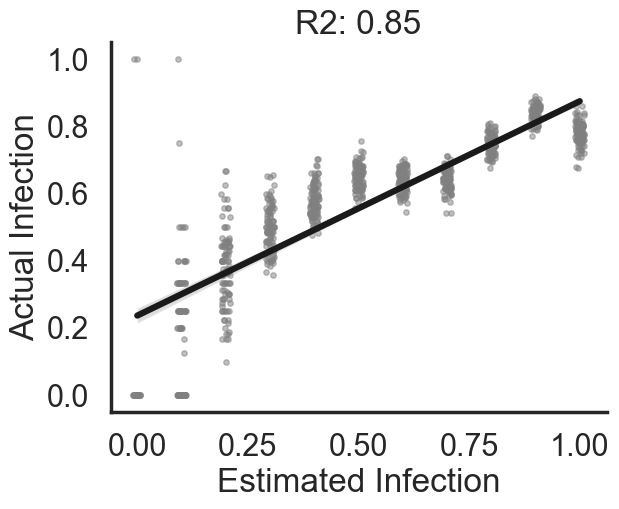

In [65]:
import matplotlib.pyplot as plt

sns.set_theme(context="poster", style="white", font_scale=1)

fig, ax = plt.subplots()

sns.regplot(
    data=bootstrap_counts,
    x="Estimated Infection",
    y="Actual Infection",
    ax=ax,
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 15},
    line_kws={"color": "k", "alpha": 1},
    fit_reg=True,
    ci=95,
    x_jitter=0.01
)

ax.set_title(
    f"R2: {corr:.2f}"
)

sns.despine()

In [66]:
fig.savefig("infection.pdf", dpi=300, bbox_inches="tight")